In [6]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
from scipy.stats import wasserstein_distance,median_abs_deviation
from scipy import stats
from tqdm.auto import tqdm
sys.path.append(os.path.abspath("../../src"))  # Adds 'src' to the module search path

In [7]:
from plot import plot_dataset_distributions,horizontal_boxplot,create_MAD_comparison_violinplot,plot_kde_grouped,plot_bar_vertical,plot_scatter,combined_plot,combined_plot_no_box
from read_data import apply_index_file
tqdm.pandas()

In [8]:
np.random.seed(42)
DATASET = "../../raw_data/massive.parquet"

# Distribution analysis

In [7]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [8]:
df.head()

,modified_sequence,label,filename,dataset,task
0,MQIFVK,52.767529,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
1,FLGFFK,107.360574,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
2,REVILNKST,96.750319,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
3,LQGIVSWGSGCAQK,150.020844,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT
4,FPFFLR,120.160845,131023_Sunil_PPT_Brain_A_02.mzML,MSV000080692,iRT


In [9]:
print(f"length of the dataset is {len(df)}")

length of the dataset is 45856811


In [10]:
df[['filename','dataset','modified_sequence']].nunique()

filename               2892
dataset                  62
modified_sequence    964395
dtype: int64

## Dataset distributions

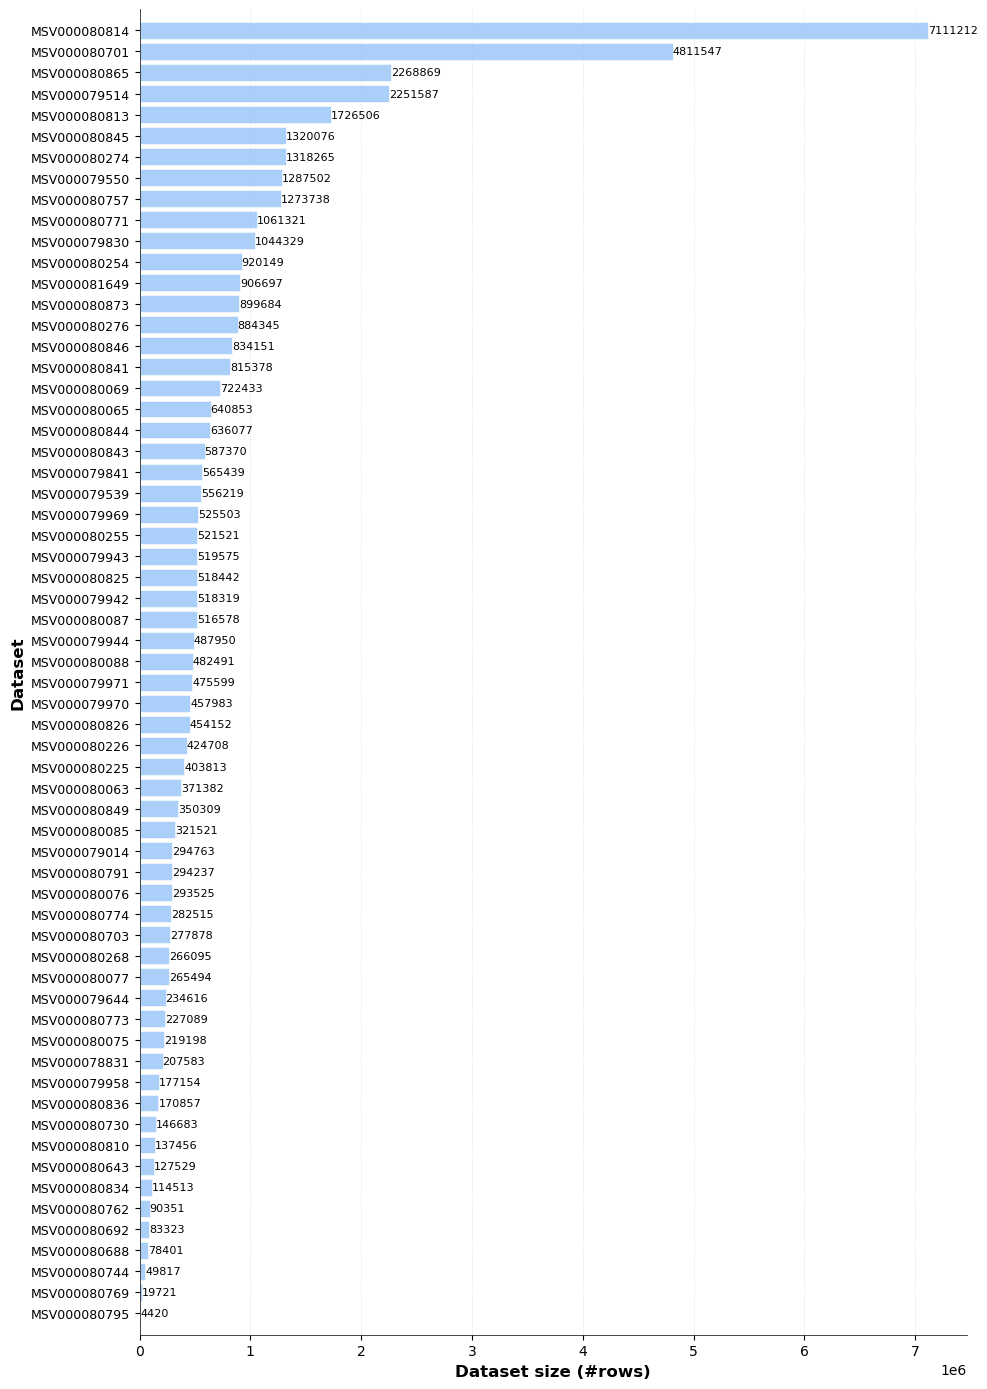

In [11]:
sequences_dataset = df.groupby('dataset')['modified_sequence'].count()
plot_dataset_distributions(sequences_dataset,'Dataset size (#rows)','Dataset')

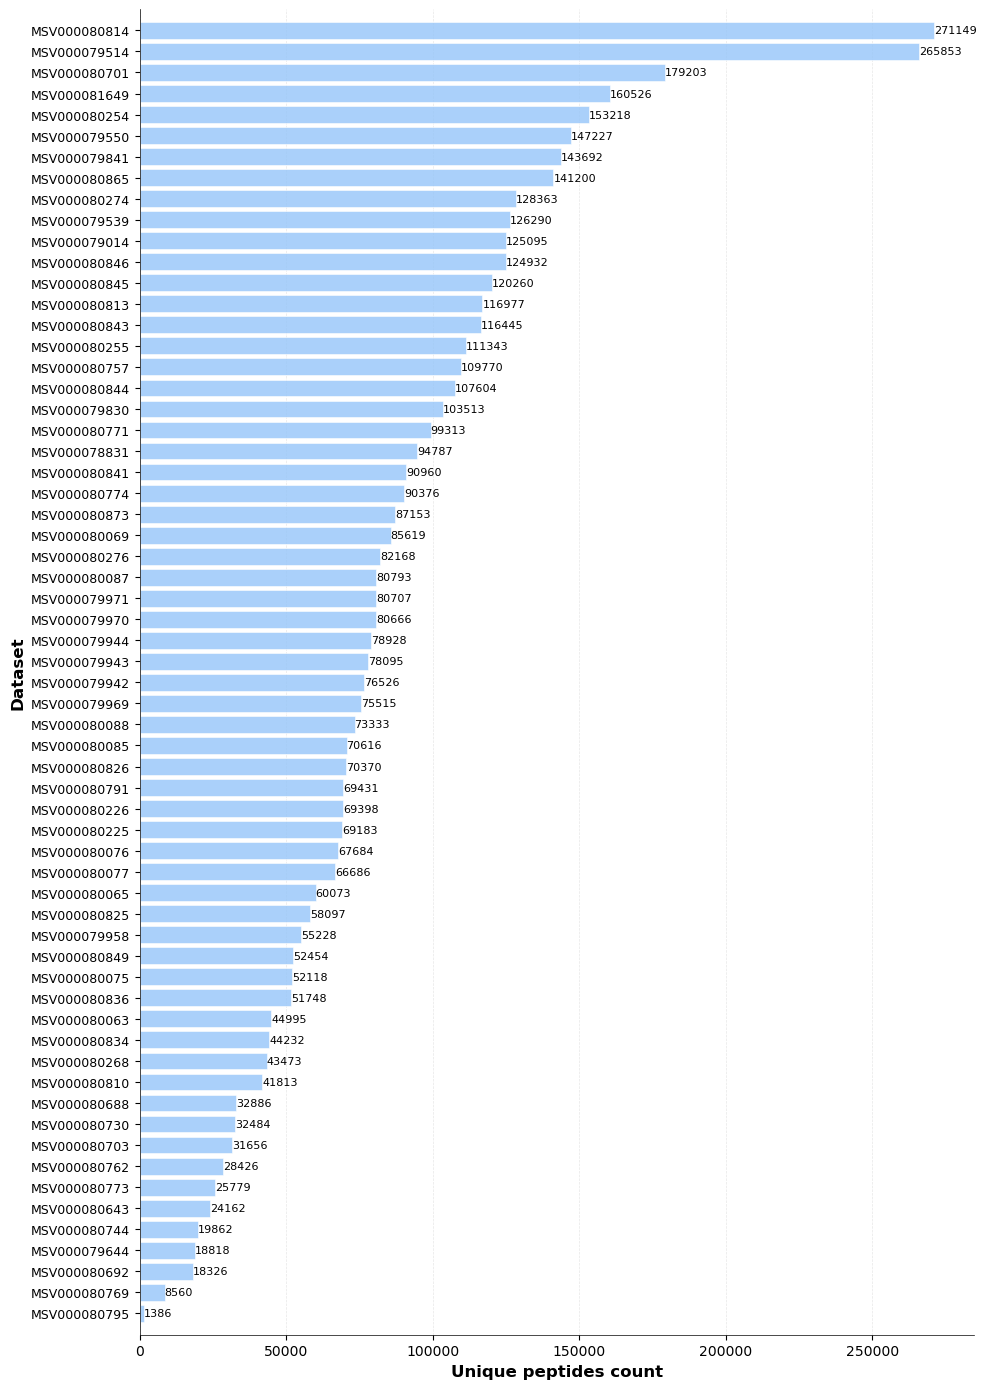

In [12]:
unique_sequences_dataset = df.groupby('dataset')['modified_sequence'].nunique()
plot_dataset_distributions(unique_sequences_dataset,'Unique peptides count','Dataset')

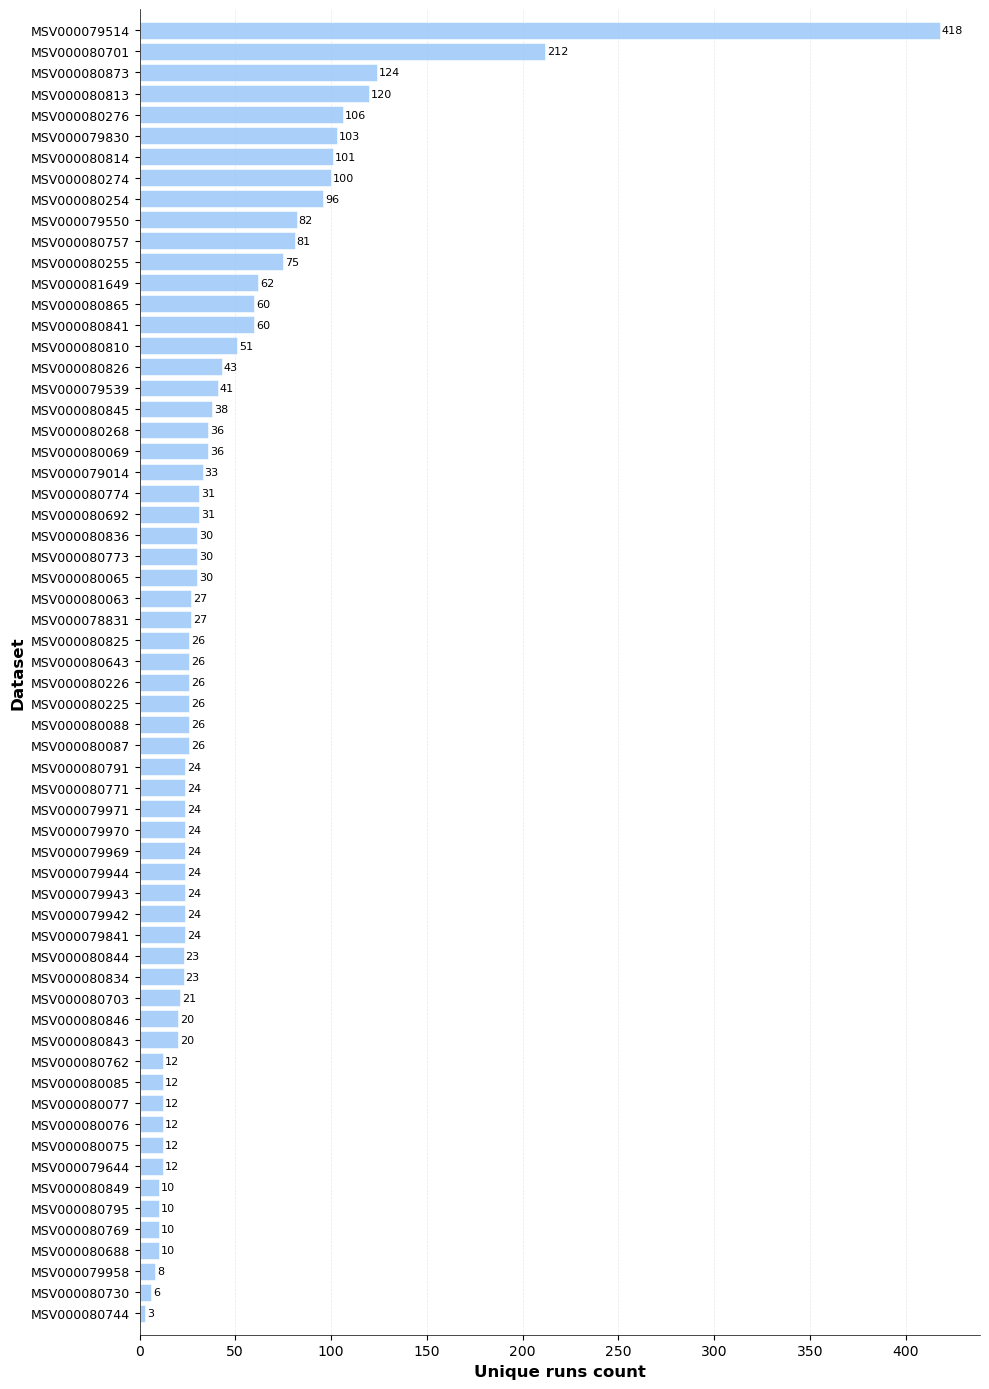

In [13]:
unique_filenames_dataset = df.groupby('dataset')['filename'].nunique()
plot_dataset_distributions(unique_filenames_dataset,'Unique runs count','Dataset')

## Peptide distributions

In [9]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [10]:
overlap_in_file = df.groupby(['modified_sequence','filename'])['filename'].count()

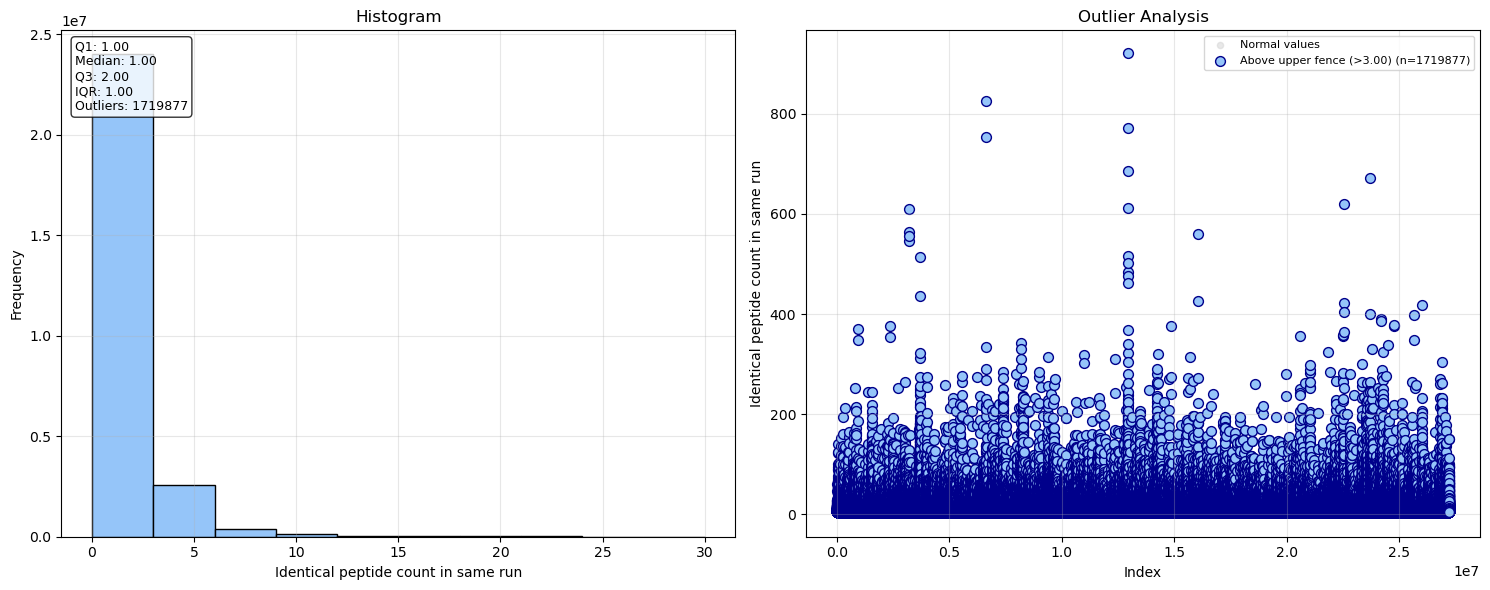

In [11]:
combined_plot_no_box(overlap_in_file, "Identical peptide count in same run",range=(0,30))

In [12]:
overlap_in_file[overlap_in_file>1]

modified_sequence      filename                                            
AAAAAAAAAAAAAAAASAGGK  20131029_Q1_SA_LuNg_FPPD_LF_SP1_1_131030091335.mzXML    2
                       20131029_Q1_SA_LuNg_FPPD_LF_SP1_2.mzXML                 2
                       20131030_Q1_SA_LuNg_StdPD_LF_SP1_DTT-IAA_1.mzXML        2
                       20131030_Q1_SA_LuNg_StdPD_LF_SP1_DTT-IAA_2.mzXML        2
                       20131030_Q1_SA_LuNg_StdPD_LF_SP1_DTT-IAA_3.mzXML        3
                                                                              ..
YYYYHR                 Seq46148_QE3.mzML                                       2
                       b1928_293T_proteinID_08A_QE3_122212.mzXML               2
                       b1945_293T_proteinID_09B_QE3_122212.mzXML               2
YYYYLTNGIR             QEx2_006849.mzML                                        4
                       QEx2_006852.mzML                                        2
Name: filename, Length: 8298455, 

In [13]:
overlap_across_file = df.groupby('modified_sequence')['filename'].nunique()

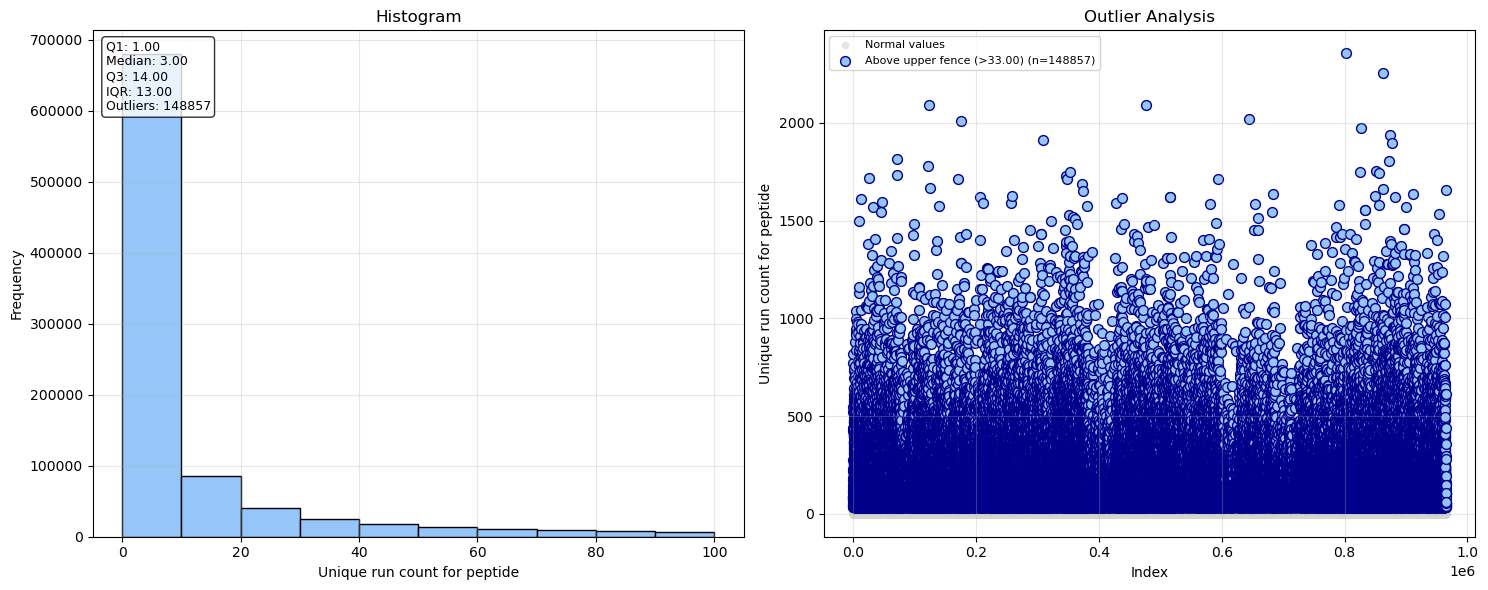

In [14]:
combined_plot_no_box(overlap_across_file, "Unique run count for peptide",range=(0,100))

In [15]:
overlap_across_file[overlap_across_file>1]

modified_sequence
AAAAAAAAAAAAAAAAG              7
AAAAAAAAAAAAAAAALAAAAGGGR     19
AAAAAAAAAAAAAAAASAGGK         25
AAAAAAAAAAAAAAAAVPR            2
AAAAAAAAAAAAAAAGA              7
                            ... 
YYYYER                        24
YYYYHR                       282
YYYYLTNGIR                     4
YYYYWHLR                       2
YYYYWHLRK                      3
Name: filename, Length: 625155, dtype: int64

# Retention time analysis

In [19]:
def median_absolute_deviation(series, threshold=None):
    if threshold is not None and len(series) < threshold:
        return None
    return stats.median_abs_deviation(series.values)

## MAD comparison

In [20]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [21]:
mad_msrun = df.groupby(['modified_sequence', 'filename'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/27236456 [00:00<?, ?it/s]

In [22]:
mad_dataset = df.groupby(['modified_sequence', 'dataset'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/5237543 [00:00<?, ?it/s]

In [23]:
mad_all = df.groupby(['modified_sequence'])['label'].progress_apply(
    lambda x: median_absolute_deviation(x, 2)
).dropna()

  0%|          | 0/964395 [00:00<?, ?it/s]

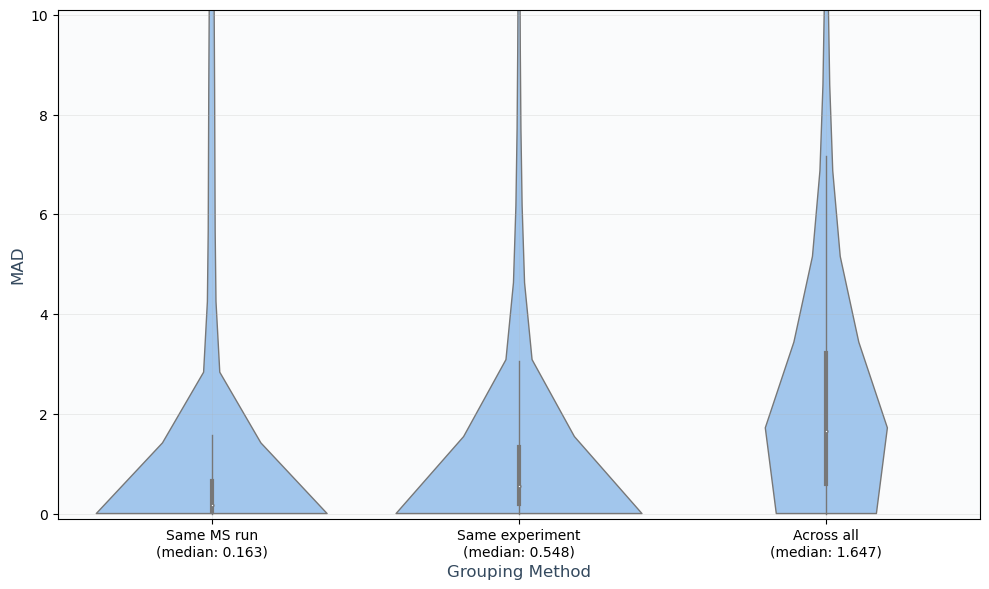

In [30]:
create_MAD_comparison_violinplot([mad_msrun,mad_dataset,mad_all],["Same MS run","Same experiment","Across all"],title="")

## MAD outliers

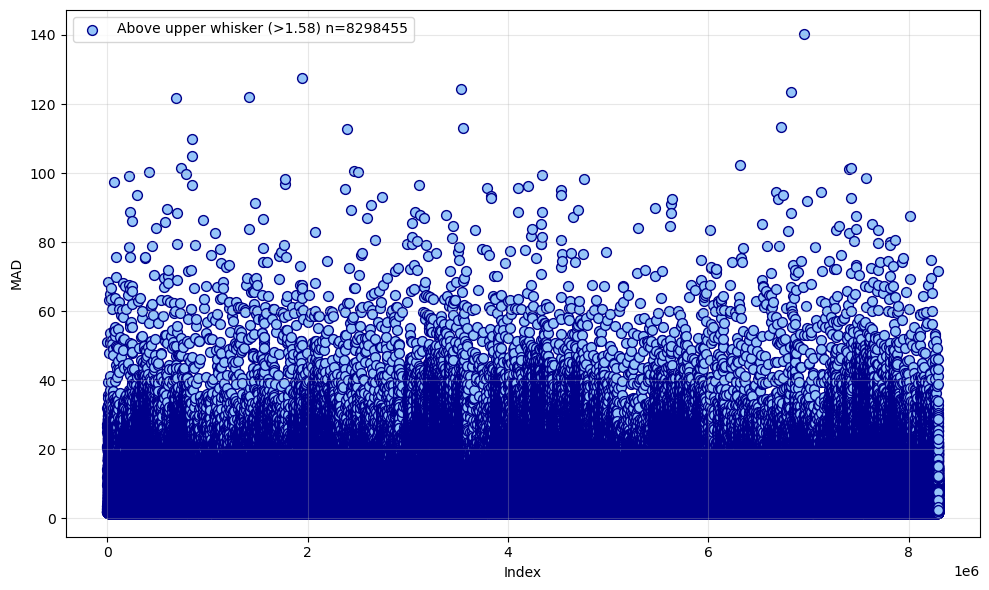

In [25]:
plot_scatter(mad_msrun,'MAD')

## KDE plots

In [26]:
df = pd.read_parquet(DATASET,engine="pyarrow")

In [27]:
overlap_all = df.groupby('modified_sequence')['filename'].nunique()
overlap_msrun = df.groupby(['modified_sequence','filename'])['filename'].count()

In [28]:
interesting_peptides_across = overlap_all[(overlap_all > 10) & (overlap_all < 30)].index
# Filter rows where the value is > 5
filtered = overlap_msrun[overlap_msrun > 5]

sequence_counts = filtered.groupby('modified_sequence').count()
interesting_peptides_inside = sequence_counts[sequence_counts > 5].index
interesting_peptides = interesting_peptides_across.intersection(interesting_peptides_inside)[:10]

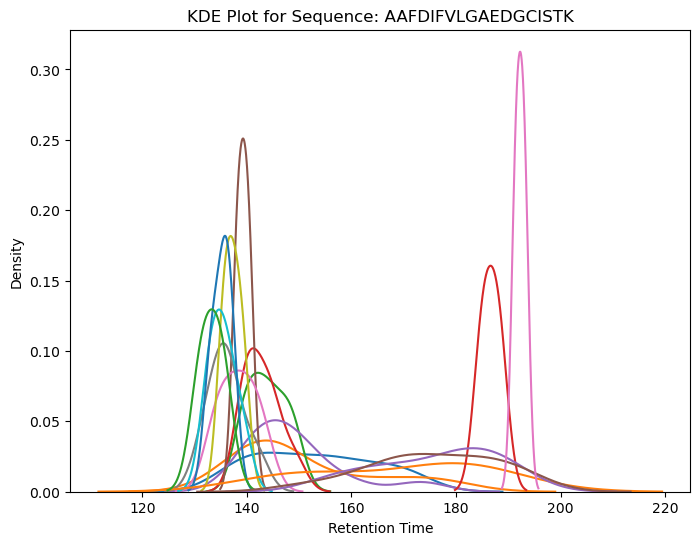

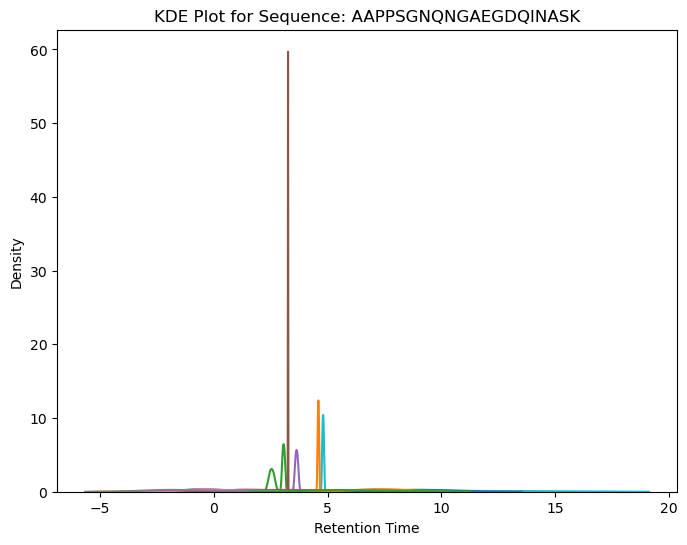

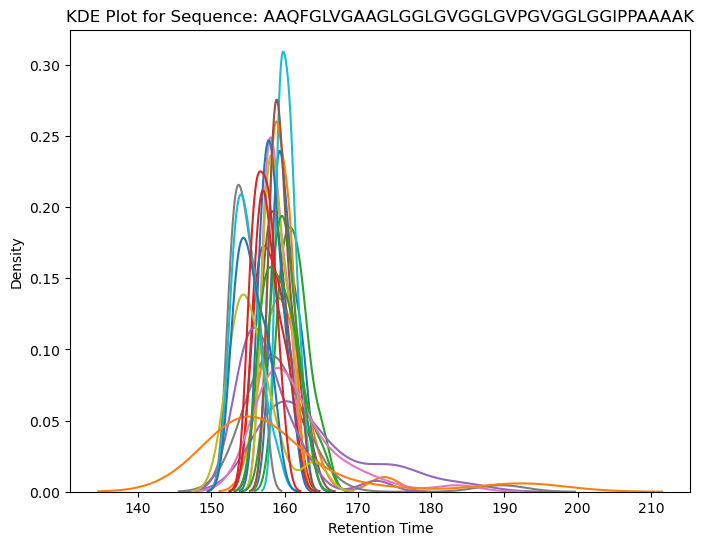

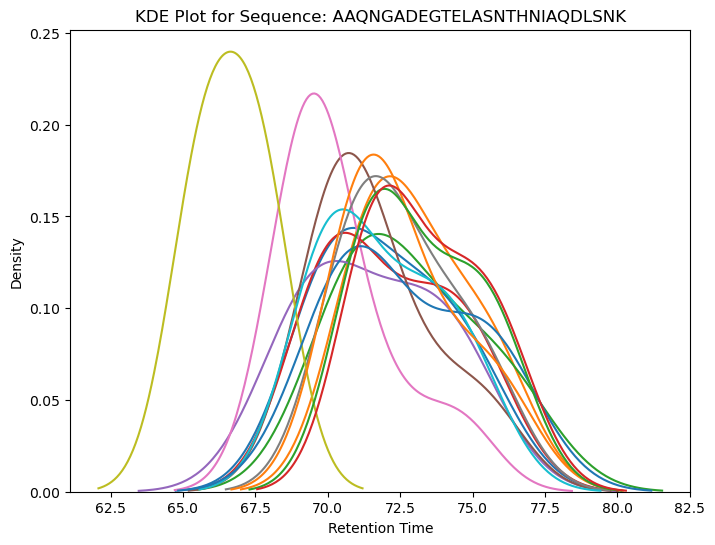

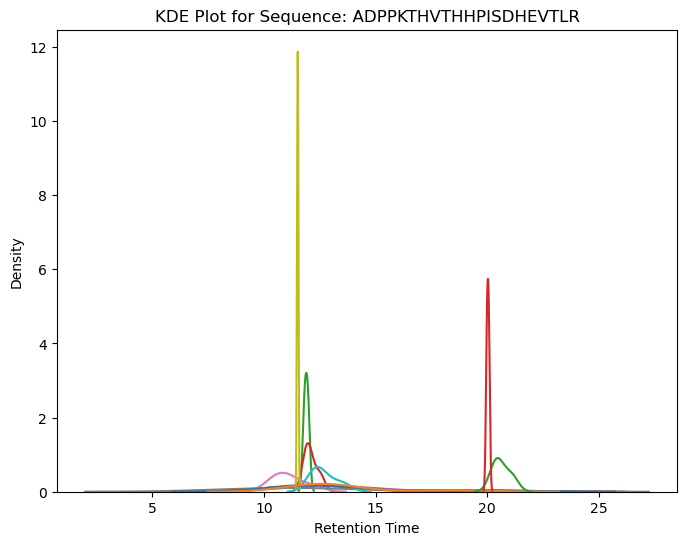

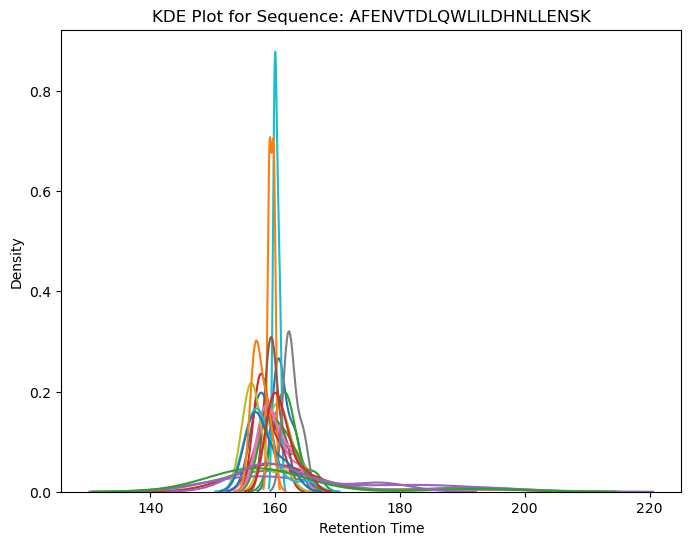

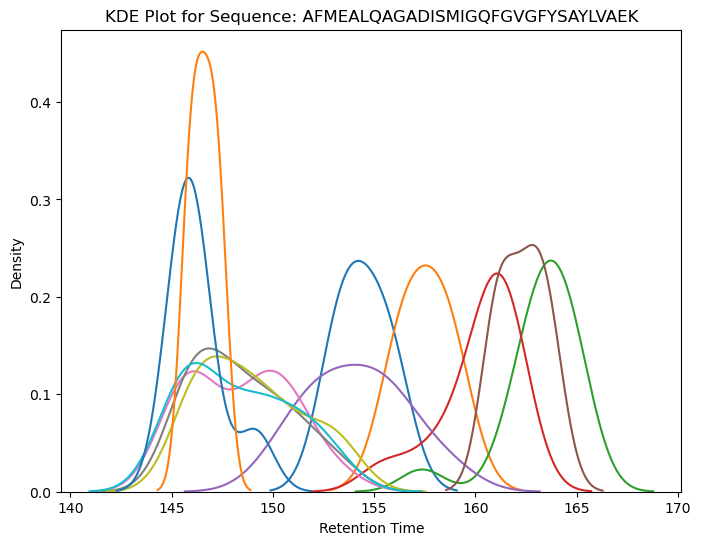

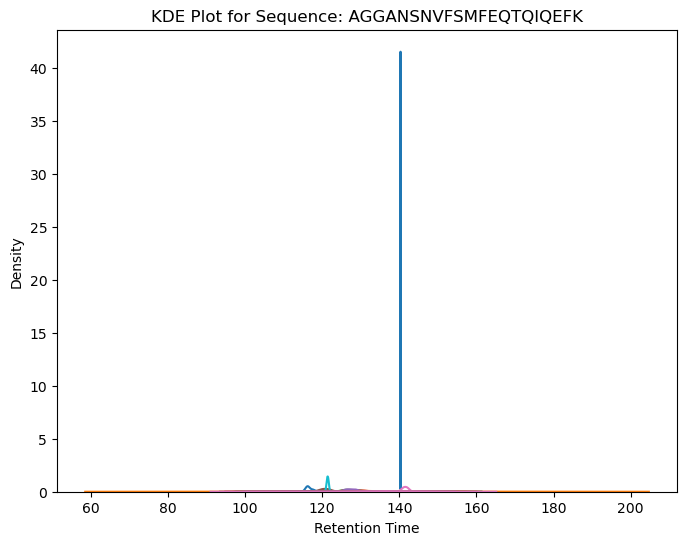

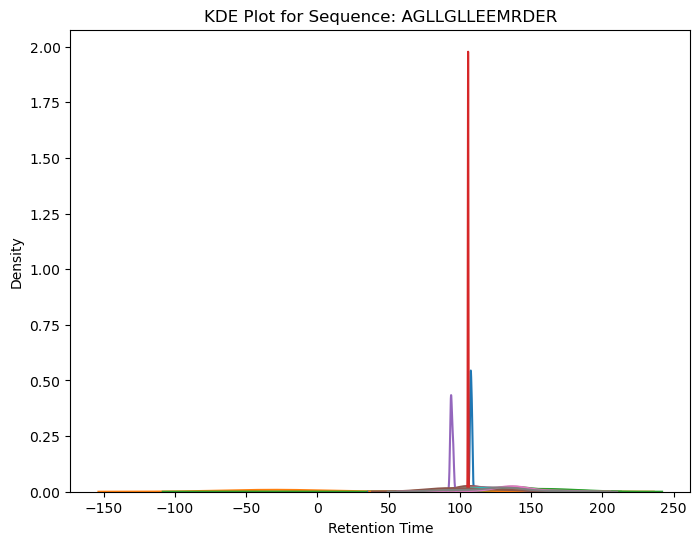

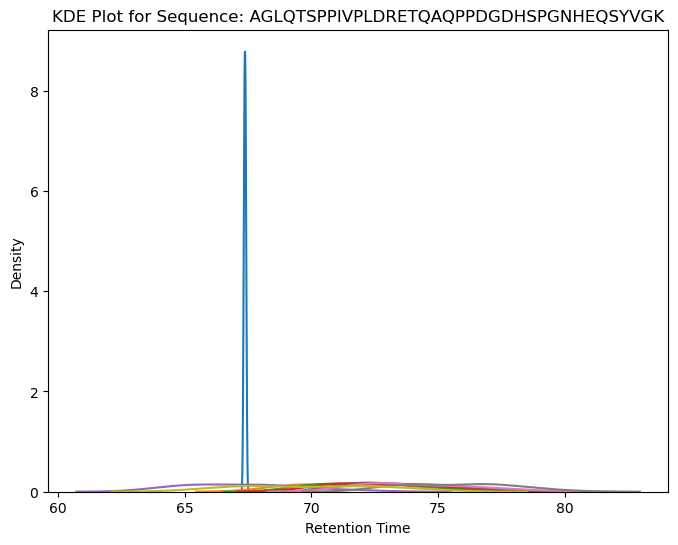

In [29]:
df_sequence = df[df['modified_sequence'].isin(interesting_peptides)]
plot_kde_grouped(df_sequence,2,legend=False)